
## Play with Himawari cloud mask, group data by bins


In [2]:
import os,sys
from glob import glob
#
import xarray as xr
import dask.array as da
#from dask.distributed import Client
from dask.dot import dot_graph
# 
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from datetime import datetime



In [5]:
# data path
dpath = '/home1/scratch/aponte/hw/mask/';

filenames = sorted(glob(dpath+'*.nc'))
print 'Number of files available: %d' %len(filenames)
Nfiles = len(filenames)

mask = xr.open_dataset(filenames[0])['QA']
mask = mask.chunk(chunks={'longitude':150,'latitude':100})

# build time line from filenames and store ut ub tule coordinate
#fname_pref='NC_H08_'+YYYYMM+DD+'_'+hh+mm+'_L2CLPbet_FLDK.02401_02401.nc'
time = [datetime.strptime(f,dpath+'NC_H08_%Y%m%d_%H%M_L2CLPbet_FLDK.02401_02401.nc') for f in filenames]

print mask

Number of files available: 23377
<xarray.DataArray 'QA' (latitude: 2401, longitude: 2401)>
dask.array<xarray-<this-array>, shape=(2401, 2401), dtype=float64, chunksize=(100, 150)>
Coordinates:
  * latitude   (latitude) float32 60.0 59.95 59.9 59.85 59.8 59.75 59.7 ...
  * longitude  (longitude) float32 80.0 80.05 80.1 80.15 80.2 80.25 80.3 ...
Attributes:
    long_name:    Quality Assurance
    units:        Dimensionless
    valid_min:    0
    valid_max:    65535
    description:  (2,1,0) Cloud Retrieval Algorithm Flag: 000=Outside of Scan...


In [36]:
# massage the mask to get cloud flag
rint = xr.ufuncs.rint
fmod = xr.ufuncs.fmod

def process_mask(mask):
    #QA:description = "
    #(2,1,0) Cloud Retrieval Algorithm Flag: 000=Outside of Scan, 001=No Cloud Mask,
    #        010=Clear, 011=Failed, 100=Successful: Low Confidence, 101=Successful: High Confidence, 110=TBD, 111=TBD; 
    #(4,3) Cloud Mask Confidence Level Flag: 00=Clear, 01=Probably Clear, 10=Probably Cloudy, 11=Cloudy; 
    #(6,5) Cloud Retrieval Phase Flag: 00=Clear, 01=Liquid Water, 10=Mixed or Uncertain, 11=Ice; 
    #(7) Spare: 0=TBD, 1=TBD;
    #(8) Sunglint Flag: 0=Yes, 1=No; 
    #(9) Snow Ice Background Possibility Flag: 0=Yes, 1=No; 
    #(11,10) Land/Water Flag: 00=Water, 01=Coastal, 10=TBD, 11=Land; 
    #(12) SOZ>80 or SAZ>70: 0=Yes, 1=No; 
    #(13) Subpixel Inhomogeneity Flag: 0=Yes, 1=No; 
    #(14) Multilayer Cloud Flag: 0=Yes, 1=No; 
    #(15) Inversion Layer Flag: 0=Yes, 1=No;" ;
    #
    fmask=xr.ones_like(mask)
    ### (2,1,0) Cloud Retrieval Algorithm Flag
    code=[]
    for i in xrange(3):
        code.append(rint(fmod(mask,2)))
        mask=mask//2
    fmask = fmask.where( (code[0]==0) & (code[1]==1) & (code[2]==0))
    ### (4,3) Cloud Mask Confidence Level Flag: 00=Clear, 01=Probably Clear, 10=Probably Cloudy, 11=Cloudy;
    code=[]
    for i in xrange(2):
        code.append(rint(fmod(mask,2)))
        mask=mask//2
    #fmask = fmask.where( (code[0]==0) & (code[1]==0) )
    #fmask = fmask.where( code[1]==1 )
    ### skips next
    for i in xrange(5):
        mask=mask//2
    ### (11,10) Land/Water Flag: 00=Water, 01=Coastal, 10=TBD, 11=Land; 
    code=[]
    for i in xrange(2):
        code.append(rint(fmod(mask,2)))
    #    #code.append(np.rint(mask%2))
        mask=mask//2
    fmask = fmask.where( (code[0]==0) & (code[1]==0) )
    
    return fmask


fmask = process_mask(mask)
fmask = fmask.fillna(0.)


In [38]:
# plot one snapshot

# note, can't download coastlines from cluster nodes:
# wget http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
# (unzip, rename)
# mv 110m_coastline.* ~/.local/share/cartopy/shapefiles/natural_earth/physical/

def plot_mask(mask, colorbar=False, title=None):
    plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.Geostationary(central_longitude=140.0));    
    mask.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
                         x='longitude', y='latitude', add_colorbar=colorbar);
    ax.coastlines(color='w')
    if title is None:
        #date = str(time[0]).split(':00.')[0].replace('T',' ')
        date = str(time[0])
        ax.set_title('HW cloud mask, '+date)
    else:
        ax.set_title(title)
    #plt.show()

# plot
plot_mask(fmask)
plt.savefig('figs/hw_snapshot.png')


[  80.           80.05000305   80.09999847 ...,  199.8999939   199.95001221
  200.        ]
[ 60.          59.95000076  59.90000153 ..., -59.90000153 -59.95000458 -60.        ]
<xarray.DataArray 'QA' (latitude_bins: 119)>
dask.array<getitem, shape=(119,), dtype=float64, chunksize=(119,)>
Coordinates:
  * latitude_bins  (latitude_bins) float64 -59.0 -58.0 -57.0 -56.0 -55.0 ...


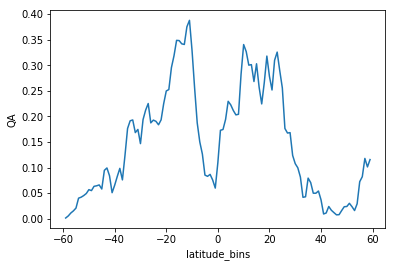

In [50]:
# 
dl = 1.
#mask['longitude'].max().values
lon_bins = np.arange(fmask['longitude'].min().values, fmask['longitude'].max().values, dl)
lat_bins = np.arange(fmask['latitude'].min().values, fmask['latitude'].max().values, dl)
#
lon_center = lon_bins[:-1]+dl
lat_center = lat_bins[:-1]+dl
print fmask['longitude'].values
print fmask['latitude'].values
mask_gp = fmask.groupby_bins('latitude', lat_bins, labels=lat_center).mean()
#
print mask_gp
plt.figure()
mask_gp.plot()
plt.show()
